## Enviroment Set Up

In [ ]:
!pip install openai==1.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.3/220.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00


In [ ]:
import json
import random
from collections import defaultdict

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data
data = read_json_file(file_path)

# Categorize questions by type
questions_by_type = defaultdict(list)
for item in data:
    questions_by_type[item["Type"]].append(item)

# Determine how many questions to sample from each type
total_questions = 30
types_count = len(questions_by_type)
print(f"Types count: {types_count}")
questions_per_type = total_questions // types_count

# Sample questions
sampled_questions = []
for question_type, questions in questions_by_type.items():
    if len(questions) >= questions_per_type:
        sampled_questions.extend(random.sample(questions, questions_per_type))
    else:

        sampled_questions.extend(questions)

#
while len(sampled_questions) < total_questions:
    additional_questions = [question for sublist in questions_by_type.values() for question in sublist if question not in sampled_questions]
    sampled_questions.extend(random.sample(additional_questions, total_questions - len(sampled_questions)))

# with open('sampled_dataset.json', 'w') as f:
#     json.dump(sampled_questions, f, indent=4)

print(f"Sampled {len(sampled_questions)} questions.")


Types count: 5
Sampled 30 questions.


In [ ]:
with open('sampled_dataset.json', 'w') as f:
    json.dump(sampled_questions, f, indent=4)

## Pre-Defined Prompt

In [ ]:
class MathDebatePrompt:
    def __init__(self):
        self.INTRODUCTION_MESSAGE = """
        You are now participating in a multi-debate framework as a math-solving agent. Your goal is to provide accurate solutions to math problems. Here are the guidelines:
        """

        self.MATH_GUIDELINES = """
        1. Carefully read the problem statement.
        2. Provide a clear, step-by-step solution to the problem.
        """

        self.SOLUTION_REQUIREMENTS = """
        1. Your solution must be clear.
        2. If multiple solutions exist, describe the conditions under which each solution is valid.
        3. Ensure your final answer in the correct format user offer you. If you do not know the answer return "Answer not found".
        """

    def get_introduction_message(self):
        return self.INTRODUCTION_MESSAGE

    def get_math_guidelines(self):
        return self.MATH_GUIDELINES

    def get_solution_requirements(self):
        return self.SOLUTION_REQUIREMENTS


## TOOL Functions

### initialize openAI

In [ ]:
from openai import OpenAI
with open('MYKEY.txt', 'r') as f:
    api_key = f.read()
API_KEY = api_key


### define basic element for high way

## Ask LLM

In [ ]:
import json
import random
import openai
import re

pre_prompt = MathDebatePrompt()
openai.api_key = API_KEY

def sample_questions(data, sample_size=1):
    if len(data) > sample_size:
        return random.sample(data, sample_size)
    else:
        return data

def send_to_chatgpt(problem_statement, model="gpt-4-0125-preview"):
    client = OpenAI(api_key=API_KEY)

    # Simplified for demonstration
    system_prompt = (f"{pre_prompt.get_introduction_message()}\n"
              f"{pre_prompt.get_math_guidelines()}\n"
              f"{pre_prompt.get_solution_requirements()}\n"
              "Once you make a final decision, output it in the following format:\n"
              "```\n"
              "Final Answer: \n"
              "    \"Answer\": {\"<answer of the problem, in the format of integer number or "
              "\"Answer not found\" no need to use any \",\" when having larger number>\"},\n"
              "```\n")
    print(problem_statement)
    user_prompt = (f"{problem_statement}\n"
                  "Once you make a final decision, output it in the following format:\n"
                  "```\n"
                  "Final Answer: \n"
                  "    \"Answer\": {\"<answer of the problem, in the format of integer number or "
                  "\"Answer not found\" no need to use any \",\" when having larger number>\"},\n"
                  "```\n")
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": problem_statement
            }
        ]
    )

    return completion.choices[0].message


def extract_answer_from_response(response):
    response_str = str(response)
    match = re.search(r'"Answer": {"?([0-9]*\.?[0-9]+)"?}', response_str)
    if match:
        return match.group(1)  # Returns the captured number as a string
    else:
        return "Answer not found"

def solve_math_problems(questions, model):
    results = []
    for question in questions:
        problem_statement = f"{question['Body']} {question['Question']}"
        # Simulating sending to agent
        response = send_to_chatgpt(problem_statement, model)
        print(f"Predicted Answer: {response}")
        # Extract the numerical answer
        predicted_answer = extract_answer_from_response(response)
        actual_answer = str(question['Answer'])  # Convert to string for comparison

        # print to check extraction
        print(f"Extracted Answer: {predicted_answer}, Actual Answer: {actual_answer}")

        results.append((predicted_answer, actual_answer))
    return results


def calculate_accuracy(results):
    correct_answers = 0
    for predicted, actual in results:
        try:
            # Skip comparison if predicted answer was not found
            if predicted == "Answer not found":
                continue
            # Compare as floats if predicted answer is a valid number
            if float(predicted) == float(actual):
                correct_answers += 1
        except ValueError as e:

            print(f"Error comparing values: predicted={predicted}, actual={actual}. Error: {e}")

    total_questions = len([result for result in results if result[0] != "Answer not found"])
    if total_questions == 0:
        return 0
    accuracy = (correct_answers / total_questions) * 100
    return accuracy

In [ ]:

file_path = 'sampled_dataset.json'
sampled_questions = read_json_file(file_path)

print(f"sampled questions: {sampled_questions}%")

results = solve_math_problems(sampled_questions, model="gpt-3.5-turbo-0125")
accuracy = calculate_accuracy(results)

print(f"Accuracy: {accuracy}%")

sampled questions: [{'ID': 'chal-31', 'Body': 'Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans.', 'Question': 'How many more bags did she find on the next day than she had on monday?', 'Equation': '( 12.0 - 7.0 )', 'Answer': 5.0, 'Type': 'Subtraction'}, {'ID': 'chal-8', 'Body': 'Paco had 41 cookies. He gave 9 cookies to his friend and ate 18 cookies.', 'Question': 'How many more cookies did he eat than those he gave to his friend?', 'Equation': '( 18.0 - 9.0 )', 'Answer': 9.0, 'Type': 'Subtraction'}, {'ID': 'chal-806', 'Body': "For Gwen's birthday she received 7 dollars. She spent some money and has 5 dollars left with her.", 'Question': 'How much money did she spend?', 'Equation': '( 7.0 - 5.0 )', 'Answer': 2.0, 'Type': 'Subtraction'}, {'ID': 'chal-9', 'Body': 'Mary is baking a cake. The recipe calls for 3 cups of sugar 10 cups of flour and 15 cups of salt. She already put in 6 cups of flour.', 'Question': 

### #origianl questions process function(Acheive)

In [ ]:
# def process_question(problem_statement, actual_answer):
#     agent1_response, agent2_response = send_problem_to_agents(problem_statement)
#     print("Agent 1 Response:", agent1_response)
#     print("Agent 2 Response:", agent2_response)
#     # Extract numerical answers from the responses
#     agent1_answer = extract_answer_from_response(agent1_response)
#     print(f"Agent 1 Answer: {agent1_answer}")
#     agent2_answer = extract_answer_from_response(agent2_response)
#     print(f"Agent 2 Answer: {agent2_answer}")

#     # If the agents' answers differ, reconcile them; otherwise, choose one
#     if agent1_answer != agent2_answer:
#         print("Agents' answers differ, reconciling...")
#         reconciled_response = reconcile_agent_responses(agent1_response, agent2_response)
#         print("Reconciled response:", reconciled_response)
#         final_answer = extract_answer_from_response(reconciled_response)
#     else:
#         print("Agents agree.")
#         final_answer = agent1_answer

#     # Compare the final answer (whether reconciled or from one agent) with the actual answer
#     print(f"Final Answer: {final_answer}, Actual Answer: {actual_answer}")
#     if final_answer == "Answer not found":
#         print(f"No valid answer found for the problem: {problem_statement}")
#         return False
#     else:
#         return float(final_answer) == float(actual_answer)

### Multidabate Process

In [ ]:
import openai

def send_problem_to_agents(problem_statement):
    print("Sending problem to Agent 1...")
    agent1_response = send_to_chatgpt(problem_statement, model="gpt-4-0125-preview")

    print("Sending problem to Agent 2...")
    agent2_response = send_to_chatgpt(problem_statement, model="gpt-3.5-turbo-0125")

    return agent1_response, agent2_response

def reconcile_agent_responses(response1, response2):
    if response1 != response2:
        print("Reconciling responses...")
        # send both responses to a third agent for a unified solution
        reconciliation_prompt = f"Agent 1 suggests:\n{response1}\n\nAgent 2 suggests:\n{response2}\n\n Summarize thought from Agent1 and Agent2 and provide a unified solution based on these responses."
        unified_solution = send_to_chatgpt(reconciliation_prompt, model="gpt-4-0125-preview")
        return unified_solution
    else:
        # If the responses are the same, no need to reconcile
        return response1

def process_question(problem_statement, actual_answer, rounds=2):
    current_problem_statement = problem_statement
    final_answer = ""

    for round_number in range(1, rounds + 1):
        print(f"Round {round_number}:")
        agent1_response, agent2_response = send_problem_to_agents(current_problem_statement)
        print("Agent 1 Response:", agent1_response)
        print("Agent 2 Response:", agent2_response)


        agent1_answer = extract_answer_from_response(agent1_response)
        print(f"Agent 1 Answer: {agent1_answer}")
        agent2_answer = extract_answer_from_response(agent2_response)
        print(f"Agent 2 Answer: {agent2_answer}")

        # reconcile them
        if agent1_answer != agent2_answer or (agent1_answer == "Answer not found" and agent2_answer == "Answer not found"):
            print("Agents' answers differ, reconciling...")
            reconciled_response = reconcile_agent_responses(agent1_response, agent2_response)
            print("Reconciled response:", reconciled_response)
            final_answer = extract_answer_from_response(reconciled_response)
            # Update the problem statement
            current_problem_statement = f"{problem_statement}\n\nReconciled solution from Round {round_number}: {reconciled_response}"
        else:
            print("Agents agree.")
            final_answer = agent1_answer
            break


    print(f"Final Answer: {final_answer}, Actual Answer: {actual_answer}")
    if final_answer == "Answer not found":
        print(f"No valid answer found for the problem: {problem_statement}")
        return False
    else:
        return float(final_answer) == float(actual_answer)

def solve_and_evaluate_problems(questions, debate_round):
    correct_count = 0
    for question in questions:
        question_id = question['ID']
        print(f"Question ID: {question_id}")
        problem_statement = f"{question['Body']} {question['Question']}"
        actual_answer = str(question['Answer'])
        if process_question(problem_statement, actual_answer, rounds = debate_round):
            correct_count += 1

    total_questions = len(questions)
    accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0
    return accuracy

In [ ]:
file_path = 'sampled_dataset.json'
sampled_questions = read_json_file(file_path)
# sampled_questions = sample_questions(data, 30)  # Assuming these functions are defined

accuracy = solve_and_evaluate_problems(sampled_questions)
print(f"Accuracy: {accuracy}%")

Sending problem to Agent 1...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Sending problem to Agent 2...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Agent 1 Response: ChatCompletionMessage(content='To find out how many more bags Tiffany found on the next day than she had on Monday, we can first calculate the total number of bags she had on the next day after finding 12 more bags.\n\nTotal bags on the next day = Bags on Monday + 12 bags\nTotal bags on the next day = 7 bags + 12 bags\nTotal bags on the next day = 19 bags\n\nNow, we can find out how many more bags Tiffany found on the next day than she had on Monday by calculating the difference between the total bags on the next day

In [ ]:
file_path = 'sampled_dataset.json'
sampled_questions = read_json_file(file_path)
# sampled_questions = sample_questions(data, 30)  # Assuming these functions are defined

accuracy = solve_and_evaluate_problems(sampled_questions, debate_round=2)
print(f"Accuracy: {accuracy}%")

Question ID: chal-31
Round 1:
Sending problem to Agent 1...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Sending problem to Agent 2...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Agent 1 Response: ChatCompletionMessage(content='To find out how many more bags Tiffany found on the next day than she had on Monday, we need to calculate the difference between the number of bags she found on Tuesday and the number of bags she had on Monday.\n\nGiven that Tiffany had 7 bags of cans on Monday and found 12 more bags on Tuesday, the total number of bags she had on Tuesday is:\n7 bags (from Monday) + 12 bags (found on Tuesday) = 7 + 12 = 19 bags\n\nNow, to find how many more bags she found o

In [ ]:
# GPT-4
file_path = 'sampled_dataset.json'
sampled_questions = read_json_file(file_path)

accuracy = solve_and_evaluate_problems(sampled_questions, debate_round=1)
print(f"Accuracy: {accuracy}%")

Question ID: chal-31
Round 1:
Sending problem to Agent 1...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Sending problem to Agent 2...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Agent 1 Response: ChatCompletionMessage(content='To find out how many more bags Tiffany found on the next day than she had on Monday, we subtract the number of bags she had on Monday from the number she found the next day.\n\nNumber of bags found the next day: 12 bags\nNumber of bags Tiffany had on Monday: 7 bags\n\nDifference = Bags found the next day - Bags on Monday\nDifference = 12 - 7\n\nLet\'s do the subtraction:\nDifference = 5\n\nTherefore, Tiffany found 5 more bags on the next day than she had on

In [ ]:
# GPT-4
file_path = 'sampled_dataset.json'
sampled_questions = read_json_file(file_path)

accuracy = solve_and_evaluate_problems(sampled_questions, debate_round=2)
print(f"Accuracy: {accuracy}%")

Question ID: chal-31
Round 1:
Sending problem to Agent 1...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Sending problem to Agent 2...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Agent 1 Response: ChatCompletionMessage(content='To find out how many more bags Tiffany found on the next day than she had on Monday, we subtract the number of bags she had on Monday from the number of bags she found the next day.\n\nNumber of bags found the next day = 12\nNumber of bags she had on Monday = 7\n\nDifference = Number of bags found the next day - Number of bags she had on Monday\n\nDifference = 12 - 7 = 5\n\nFinal Answer: \n    "Answer": {"5"},', role='assistant', function_call=None, tool_ca

In [ ]:
# GPT-4 & GPT-3.5
file_path = 'sampled_dataset.json'
sampled_questions = read_json_file(file_path)

accuracy = solve_and_evaluate_problems(sampled_questions, debate_round=2)
print(f"Accuracy: {accuracy}%")

Question ID: chal-31
Round 1:
Sending problem to Agent 1...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Sending problem to Agent 2...
Tiffany was collecting cans for recycling. On monday she had 7 bags of cans. The next day she found 12 more bags worth of cans. How many more bags did she find on the next day than she had on monday?
Agent 1 Response: ChatCompletionMessage(content='To find out how many more bags Tiffany found on the next day than she had on Monday, we need to subtract the number of bags she had on Monday from the number of bags she found the next day.\n\nNumber of bags found the next day = 12\nNumber of bags she had on Monday = 7\n\nDifference = Number of bags found the next day - Number of bags she had on Monday\nDifference = 12 - 7 = 5\n\nSo, Tiffany found 5 more bags on the next day than she had on Monday.\n\nFinal

# result:  
no debate : 81
1. 1 round debate: 83.33333333333334%
2. 2 rounds debate: 90.00% (question of chal-278 is correct but mistakend counted as agent out format accidently changed)

GPT 4 : 1.no 86.666%
        2. 1 round 90%.
        3. 2 round 90%.
        
GPT 4 & GPT 3.5  86.666%

### Sequentially agressive debating style

In [ ]:
def send_problem_to_agents_sequentially(problem_statement):
    print("Sending problem to Agent 1...")
    agent1_response = send_to_chatgpt(problem_statement, model="gpt-4-0125-preview")

    print("Sending Agent 1's response to Agent 2 for consideration from a different angle...")
    agent2_prompt = f"Agent 1 suggests:\n{agent1_response}\n\n Arguing somthing that Agent1 might be wrong and generate your answer, for example agent1 is mistaking some useless info from question(take a simple subtraction quetsion to ratio) and made this question complex"
    agent2_response = send_to_chatgpt(agent2_prompt, model="gpt-4-0125-preview")

    return agent1_response, agent2_response

def reconcile_with_agent3(response1, response2):
    print("Forwarding responses to Agent 3 for final deliberation...")
    agent3_prompt = (
        f"Agent 1 suggests:\n{response1}\n\nAgent 2, after considering Agent 1's response, suggests:\n{response2}\n\n"
        "Summarize thoughts from Agent 1 and Agent 2. Provide a unified solution based on these responses, "
        "relying more on the Agent2 response unless an obvious mistake is found."
    )
    final_decision = send_to_chatgpt(agent3_prompt, model="gpt-4-0125-preview")
    return final_decision

def process_question(problem_statement, actual_answer, rounds=2):
    current_problem_statement = problem_statement
    final_answer = ""

    for round_number in range(1, rounds + 1):
        print(f"\nRound {round_number}:")
        # Sequentially send the problem to Agent 1, then Agent 2's response builds on Agent 1, and finally, Agent 3 reconciles
        agent1_response, agent2_response = send_problem_to_agents_sequentially(current_problem_statement)
        print("Agent 1 Response:", agent1_response)
        print("Agent 2 Response:", agent2_response)

        agent1_answer = extract_answer_from_response(agent1_response)
        agent2_answer = extract_answer_from_response(agent2_response)

        # Reconcile
        if agent1_answer != agent2_answer or (agent1_answer == "Answer not found" and agent2_answer == "Answer not found"):
            print("Reconciling...")
            reconciled_response = reconcile_with_agent3(agent1_response, agent2_response)
            print("Reconciled response:", reconciled_response)
            final_answer = extract_answer_from_response(reconciled_response)
            # Prepare the problem statement for the next round if necessary
            current_problem_statement += f"\n\nRound {round_number} reconciled solution: {reconciled_response}"
        else:
            print("Agents reached a consensus without needing further reconciliation.")
            final_answer = agent1_answer  # or agent2_answer since they agree
            break  # Exit the loop early if agents agree

    # Compare the final answer with the actual answer
    print(f"\nFinal Answer: {final_answer}, Actual Answer: {actual_answer}")
    if final_answer == "Answer not found" or final_answer == "":
        print(f"No valid answer found for the problem: {problem_statement}")
        return False
    else:
        return float(final_answer) == float(actual_answer)

def solve_and_evaluate_problems(questions, debate_rounds=2):
    correct_count = 0
    for question in questions:
        question_id = question['ID']
        print(f"\nProcessing Question ID: {question_id}")
        problem_statement = f"{question['Body']} {question['Question']}"
        actual_answer = str(question['Answer'])

        if process_question(problem_statement, actual_answer, rounds=debate_rounds):
            correct_count += 1

    total_questions = len(questions)
    accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0
    print(f"\nOverall Accuracy: {accuracy}%")
    return accuracy

Single case study

In [ ]:
#single question
single_question = {
    "ID": "chal-216",
    "Body": "Mary is baking a cake. The recipe calls for 5 cups of flour and 14 cups of sugar. She already put in 10 cups of flour and 2 cups of sugar.",
    "Question": "How many more cups of sugar does she need to add?",
    "Equation": "( 14.0 - 2.0 )",
    "Answer": 12.0,
    "Type": "Subtraction"
}

questions = [single_question]


debate_rounds = 1

accuracy = solve_and_evaluate_problems(questions, debate_rounds)

print(f"Test Accuracy: {accuracy}%")



Processing Question ID: chal-216

Round 1:
Sending problem to Agent 1...
Mary is baking a cake. The recipe calls for 5 cups of flour and 14 cups of sugar. She already put in 10 cups of flour and 2 cups of sugar. How many more cups of sugar does she need to add?
Sending Agent 1's response to Agent 2 for consideration from a different angle...
Agent 1 suggests:
ChatCompletionMessage(content='To solve this problem, we need to understand the ratio of flour to sugar according to the recipe and then calculate how much more sugar Mary needs to add based on how much flour she already added.\n\nThe recipe calls for:\n- 5 cups of flour\n- 14 cups of sugar\n\nMary already put in:\n- 10 cups of flour\n- 2 cups of sugar\n\nWe first find the ratio of flour to sugar in the recipe. The ratio is \\(5:14\\).\n\nMary added double the amount of flour required by the recipe (since \\(10 \\div 5 = 2\\)). To maintain the right proportions, she should also double the amount of sugar, which means she should h

In [ ]:
# import json
# import random

# def get_math_statement(question):
#     return f"{question['Body']} {question['Question']}"

# def process_questions_through_framework(questions):
#     correct_count = 0
#     for question in questions:
#         problem_statement = get_math_statement(question)
#         agent1_response, agent2_response = send_problem_to_agents(problem_statement)
#         final_solution = reconcile_agent_responses(agent1_response, agent2_response)

#         try:
#             final_answer = float(final_solution.split()[-1])  # Simple heuristic to extract numerical answer
#             if abs(final_answer - float(question['Answer'])) < 0.01:  # Allowing some tolerance
#                 correct_count += 1
#         except ValueError:
#             print(f"Could not interpret final solution for question ID {question['ID']} as a number.")

#     return correct_count

# # Load and sample questions
# file_path = 'SVAMP.json'
# data = read_json_file(file_path)
# sampled_questions = sample_questions(data)

# # Process questions and calculate accuracy
# correct_answers = process_questions_through_framework(sampled_questions)
# accuracy = (correct_answers / len(sampled_questions)) * 100

# print(f"Accuracy: {accuracy}%")


## Customization TOOLs

# Plot obs

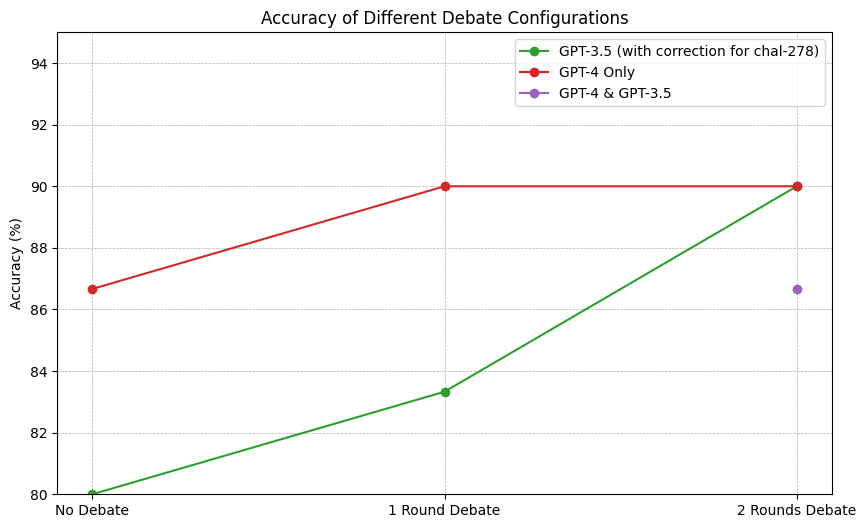

In [ ]:
import matplotlib.pyplot as plt

# Data preparation

gpt_3_5 = [80, 83.33, 90]  # Corrected value for chal-278 included
gpt_4 = [86.666, 90, 90]
gpt_4_3_5 = [None, None, 86.666]  # Only one value for GPT 4 & GPT 3.5


labels = ['No Debate', '1 Round Debate', '2 Rounds Debate']
indices = range(len(labels))


plt.figure(figsize=(10, 6))

plt.plot(indices, gpt_3_5, label='GPT-3.5 (with correction for chal-278)', marker='o', linestyle='-', color='tab:green')
plt.plot(indices, gpt_4, label='GPT-4 Only', marker='o', linestyle='-', color='tab:red')
plt.plot(indices, gpt_4_3_5, label='GPT-4 & GPT-3.5', marker='o', linestyle='-', color='tab:purple')


plt.xticks(indices, labels)
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Debate Configurations')
plt.ylim(80, 95)

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()


# Training model